In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pint
from pathlib import Path

ureg = pint.UnitRegistry()
# %matplotlib widget

In [2]:
def get_zero_crosses(inp, thresh):
    inpcross = inp > thresh
    inpcross = (inpcross[:-1] ^ inpcross[1:]).nonzero()[0]
    return inpcross[1:], inpcross[1:] - inpcross[:-1]

In [3]:
def rolling_average(data, n):
    return np.convolve(data, [1]*n, mode="same") / n

In [4]:
def find_local_minima(data: np.array, n_window: int, thresh: float = 0.1):
    def _len(dat, val):
        return (dat != val).nonzero()[0][0]
    minima = []
    for i in range(len(data)-n_window):
        s = data[i:i+n_window]
        if s.argmin() == n_window//2 and abs(s.max() - s.min()) > thresh:
            ii = i + n_window//2
            # Shift to be at center of similar values
            minima.append(ii + _len(data[ii:], s.min())//2)
    return minima

In [5]:
def find_edges(data: np.array, thresh: float):
    def _len_and_mag(d):
        try:
            iend = (d < 0).nonzero()[0][0]
            return iend, d.cumsum()[iend]
        except IndexError:
            return 1, 0
    
    ddata = data[1:] - data[:-1]
    edges = []
    i = 0
    while i < len(ddata):
        if ddata[i] > 0:
            l, m = _len_and_mag(ddata[i:])
            if m > thresh:
                edges.append(i)
            i += l
        else:
            i += 1
    return edges

In [6]:
def calc_dist(d1, d2, fs):
    ## Find large edges in ctrl
    edges = find_edges(d1, 15)
    
    ## Clip d2 to threshold
    dd2 = d2[1:] - d2[:-1]
    ithr = (abs(dd2) > 0.1).nonzero()[0][0]
    _d2 = d2[ithr:]
    
    ## Get minima of zero cross timings
    cross, crossD = get_zero_crosses(_d2, 1.635)
    crossD_avr = rolling_average(crossD, 6)
    minima = np.array([cross[i] for i in find_local_minima(crossD_avr, 10, 0.1)])
    
    T1 = (minima[0] - edges[1] + ithr) / fs
    T2 = (minima[1] - edges[3] + ithr) / fs
    T3 = (minima[2] - edges[5] + ithr) / fs
    T = (T1 + T2 + T3) / 3
    return T * 343

# calc_dist(datin, datout, 1e6)

In [7]:
inpath = Path("data/20v/short_v2")

rdata = []
for f in inpath.glob("*.json"):
    print(f)
    with open(f, "r") as fd:
        rdata.append(json.loads(fd.read()))

data/20v/short_v2/110.66cm_220508-153655.json
data/20v/short_v2/120.24cm_220508-153434.json
data/20v/short_v2/107.46cm_220508-153743.json
data/20v/short_v2/112.22cm_220508-153613.json
data/20v/short_v2/119.96cm_220508-153519.json
data/20v/short_v2/120.52cm_220508-153221.json


In [8]:
res = dict()
for dat in rdata:
    fs = dat["fs"]
    dist = dat["dist"]
    data = np.array(dat["data"])
    print(dist)
    
    distances = []
    for i, d in enumerate(data):
        ch1, ch2 = d.T
        distances.append(calc_dist(ch2, ch1, fs))
    distances = np.array(distances)
    res[dist] = distances

110.66
120.24
107.46
112.22
119.96
120.52


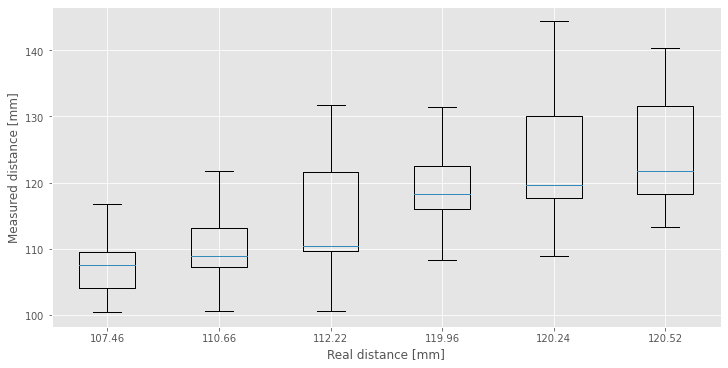

In [12]:
plt.close("all")
fig, ax = plt.subplots(figsize=(10,5))

keys = sorted(res.keys())
data = np.array([1000*res[k] for k in keys])
meds = np.median(data, 1)
data += min(keys) - min(meds)
ax.boxplot(data.T, labels=keys, showfliers=False);
# ax.set_xticklabels(keys, rotation=45);
ax.set_xlabel("Real distance [mm]")
ax.set_ylabel("Measured distance [mm]")
fig.savefig("plot/boxplot.pdf")

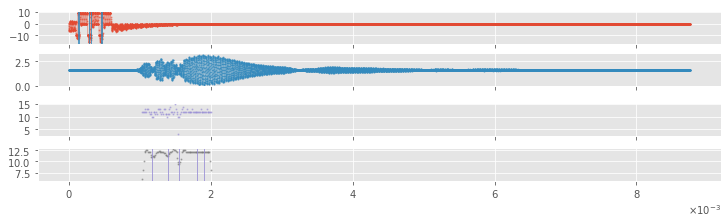

In [10]:
inpath = Path("data/long/300cm_220508-132854.json")
plt.close("all")
with open(inpath, "r") as fd:
    raw_data = json.load(fd)
fs = raw_data["fs"]
data = np.array(raw_data["data"])

plt.close("all")
fig, axd = plt.subplot_mosaic([
    ["t"], ["b"], ["bb"], ["bbb"]
], sharex=True)

for idx, dat in enumerate(data[:1]):
    datin = dat[1:,1]
    datout = dat[1:,0]
    
    datinedge = abs(datin[:-1] - datin[1:])
    sidx = (datinedge > 0.1).nonzero()[0][0]
    
    datin  =  datin[sidx:]
    datout = datout[sidx:]

    x = np.arange(len(datin)) / fs

    ithresh = (datout > 1.635+0.5).nonzero()[0][0] - 50
    doutth = datout[ithresh:ithresh+1000]
    cross, crossD = get_zero_crosses(doutth, 1.635)
    crossD_f = rolling_average(crossD, 6)
    minima = [cross[i]/fs for i in find_local_minima(crossD_f, 10, 0.1)]
    cross += ithresh
    
    edges = find_edges(datin[:1500], 15)

    axd["t"]  .plot(x,        datin,    'o-', c=f"C0", alpha=0.5, markersize=1)
    axd["b"]  .plot(x,        datout,   'o-', c=f"C1", alpha=0.5, markersize=1)
    axd["bb"] .plot(cross/fs, crossD,   'o',  c=f"C2", alpha=0.5, markersize=1)
    axd["bbb"].plot(cross/fs, crossD_f, 'o',  c=f"C3", alpha=0.5, markersize=1)
    
    for e in edges:
        axd["t"].axvline(e/fs, c="C1")
    for m in minima:
        axd["bbb"].axvline(m+ithresh/fs, c="C2")